# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.924229717530089

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.680006252682571

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [6]:
seed = 155
np.random.seed(seed)
x = np.random.exponential(size=sample_size)
y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
x = x[:, None]

In [7]:
from sklearn.tree import DecisionTreeRegressor
np.random.seed(seed)
dtr = DecisionTreeRegressor(random_state=42)

In [8]:
dtr.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [9]:
X_test = linspace[:,None]

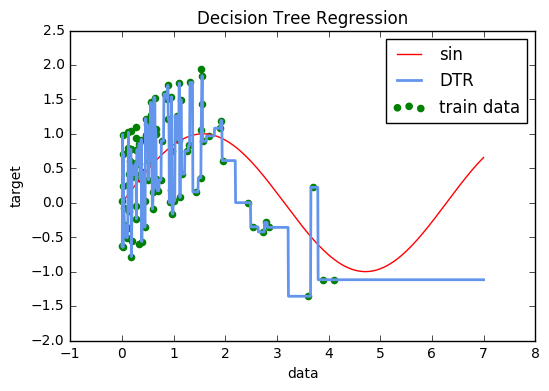

In [10]:
y_1 = dtr.predict(X_test)
# Plot the results
plt.figure()
plt.plot(X_test, f(X_test), label="sin", color='red')
plt.scatter(x, y, label="train data", color='green')
plt.plot(X_test, y_1, color="cornflowerblue",
         label="DTR", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


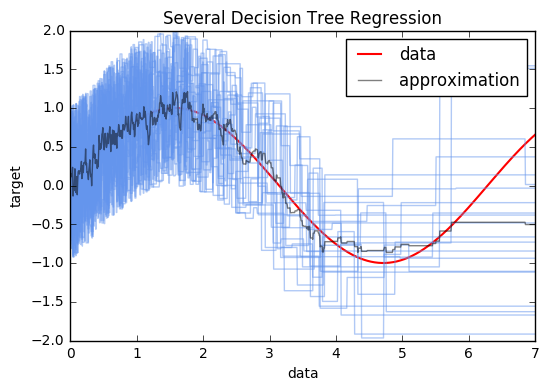

In [11]:
np.random.seed(seed)
dtr = DecisionTreeRegressor(random_state=seed)
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several Decision Tree Regression")
plt.legend()
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


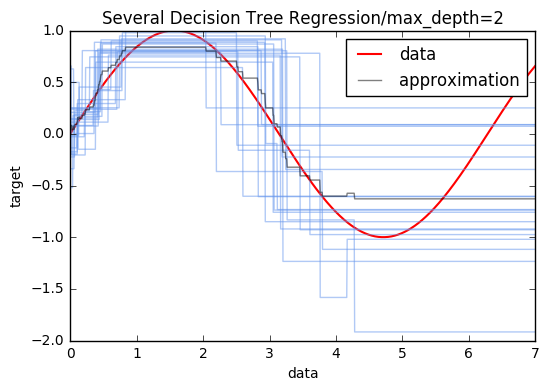

In [12]:
np.random.seed(seed)
dtr = DecisionTreeRegressor(random_state=seed, max_depth=2)
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several Decision Tree Regression/max_depth=2")
plt.legend()
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


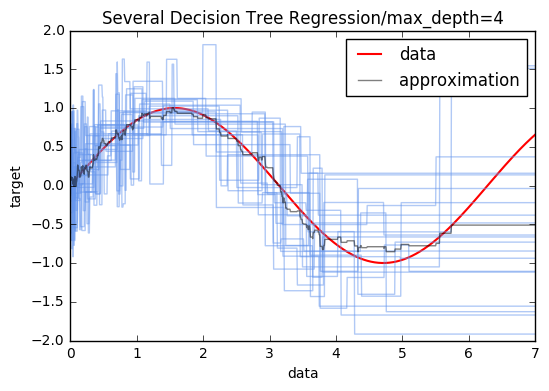

In [13]:
np.random.seed(seed)
dtr = DecisionTreeRegressor(random_state=seed, max_depth=4)
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several Decision Tree Regression/max_depth=4")
plt.legend()
plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


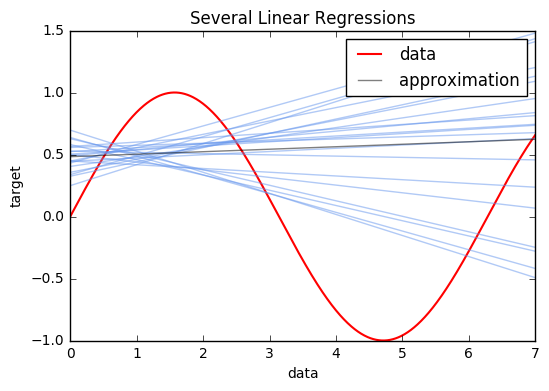

In [14]:
from sklearn.linear_model import LinearRegression
np.random.seed(seed)
dtr = LinearRegression()
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several Linear Regressions")
plt.legend()
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


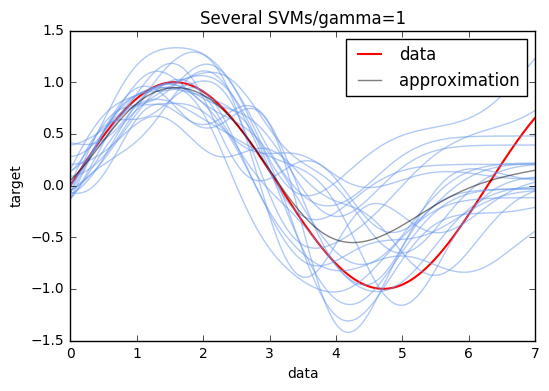

In [15]:
from sklearn.svm import SVR
np.random.seed(seed)
dtr = SVR(gamma=1)
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several SVMs/gamma=1")
plt.legend()
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:2644: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


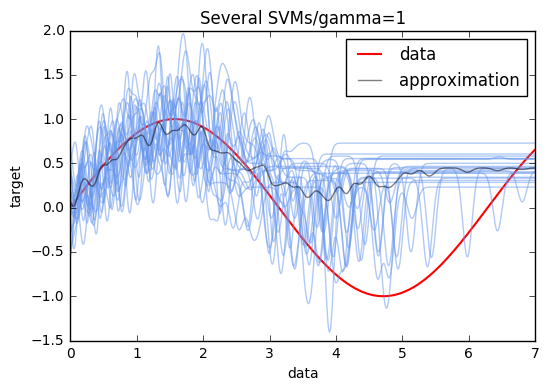

In [16]:
from sklearn.svm import SVR
np.random.seed(seed)
dtr = SVR(gamma=100)
plt.figure()
plt.plot(X_test, f(X_test), color='red',
            c="darkorange", label="data", linewidth=1.5)
mean_df = np.empty([len(X_test), samples_num])
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    y = f(x) + np.random.uniform(low=-1, high=1, size = sample_size)
    x = x[:, None]
    dtr.fit(x,y)
    pred = dtr.predict(X_test)
    plt.plot(X_test, pred, color="cornflowerblue",
          linewidth=1, alpha=0.5)
    mean_df[:,i] = pred
plt.plot(X_test, np.mean(mean_df,axis=1), color='black', label='approximation', alpha=0.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Several SVMs/gamma=1")
plt.legend()
plt.show()

Линейная регрессия не смогла поймать вид данных, что вполне логично.

SVM с гаммой равной единице очень хорошо уловил нелинейность данных, особенно где было много точек для обучения.

Гамма равная 100 избыточна и не улучшает модель.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [17]:
import pandas as pd
mush = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
y_mush = mush[0]
x_mush = mush.loc[:,1:]

In [41]:
ttt = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
y_ttt = ttt.iloc[:,-1]
x_ttt = ttt.iloc[:,:-1]

In [42]:
car = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
y_car = np.ones(car.shape[0])
y_car[np.where(car.iloc[:,-1] == 'acc')] = 0
y_car[np.where(car.iloc[:,-1] == 'unacc')] = 0
x_car = car.iloc[:,:-1]

In [43]:
nur = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)
y_nur = np.ones(nur.shape[0])
y_nur[np.where(nur.iloc[:,-1] == 'not_recom')] = 0
y_nur[np.where(nur.iloc[:,-1] == 'recommend')] = 0
x_nur = nur.iloc[:,:-1]

In [24]:
from sklearn.preprocessing import LabelEncoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

К сожалению, в чате я так и не дождался ответа на вопрос о том, чем отличается "все признаки категориальные" от "правильного разбиения". Если понимать под "все категориальные" one-hot-encoding даже для вещественных признаков - то это очень глупое занятие и можно не обучая модель сказать, что этобудет работать хуже всего.

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

def DTtask(x_mush, y_mush, clf, dataset):
    enc = LabelEncoder()
    y = enc.fit_transform(y_mush)
    x_num = MultiColumnLabelEncoder(columns = x_mush.columns).fit_transform(x_mush)
    x_cat = pd.get_dummies(x_mush)
    cv_cat = cross_val_score(clf, x_cat, y, scoring=make_scorer(accuracy_score), cv=10)
    cv_num = cross_val_score(clf, x_num, y, scoring=make_scorer(accuracy_score), cv=10)
    print('Датасет ', dataset, ', accuracy для вещественных признаков',np.mean(cv_num))
    print('Датасет ', dataset, ', accuracy для правильно разбитых признаков',np.mean(cv_cat))

In [87]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
DTtask(x_mush, y_mush, clf, 'mushrooms')

Датасет  mushrooms , accuracy для вещественных признаков 0.958154101886
Датасет  mushrooms , accuracy для правильно разбитых признаков 0.968265682657


In [86]:
DTtask(x_ttt, y_ttt, clf, 'tic-tac-toe')

Датасет  tic-tac-toe , accuracy для вещественных признаков 0.75943954603
Датасет  tic-tac-toe , accuracy для правильно разбитых признаков 0.805143335142


In [85]:
DTtask(x_car, y_car, clf, 'cars')

Датасет  cars , accuracy для вещественных признаков 0.940390269981
Датасет  cars , accuracy для правильно разбитых признаков 0.825187115744


In [84]:
DTtask(x_nur, y_nur, clf, 'nursery')

Датасет  nursery , accuracy для вещественных признаков 0.999691477008
Датасет  nursery , accuracy для правильно разбитых признаков 0.999845797995


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Для первого, второго и последнего датасетов one-hot-encoding категориальных факторов работает лучше. Для грибов и крестиков-ноликов это очевидно, ведь категории в признаках не связаны между собой. 

В cars и nursery категории порядковые. Видимо, LabelEncoder удачно уловил порядок в датасете с автомобилями и неудачно в последнем. В таких случаях лучше не полагаться на случайность, а разметить порядок категорий вручную.

Также случайность присутствует в разбиении на кросс валидации

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [18]:
wine = pd.read_csv('winequality-red.csv', sep = ';')

In [19]:
y_w = wine['quality']
x_w = wine.drop('quality', axis=1)

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
dtc = DecisionTreeClassifier()
bc = BaggingClassifier(n_estimators=100, random_state=seed, n_jobs=3)
bc_half = BaggingClassifier(n_estimators=100, random_state=seed, n_jobs=3, max_features=0.5)
rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=3)

In [94]:
print(np.mean(cross_val_score(dtc, x_w, y_w, scoring=make_scorer(accuracy_score), cv=3)), ' Decision tree')
print(np.mean(cross_val_score(bc, x_w, y_w, scoring=make_scorer(accuracy_score), cv=3)), ' Bagging classifier')
print(np.mean(cross_val_score(bc_half, x_w, y_w, scoring=make_scorer(accuracy_score), cv=3)), ' Bagging classifier with random features')
print(np.mean(cross_val_score(rf, x_w, y_w, scoring=make_scorer(accuracy_score), cv=3)), ' Random forest')

0.445266160298  Decision tree
0.552925713037  Bagging classifier
0.547932061002  Bagging classifier with random features
0.555415551743  Random forest


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [123]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x_w, y_w, train_size = 0.7, test_size = 0.3, random_state = seed, shuffle=True)

In [111]:
ofrf = RandomForestClassifier(warm_start=True, random_state=seed, n_jobs=4)
score = np.ones([50,2])
for i in range(50):
    ofrf.set_params(n_estimators=(100*(i+1)))
    ofrf.fit(x_tr, y_tr)
    score[i,:] = [(100*(i+1)),accuracy_score(y_te, ofrf.predict(x_te))]
    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


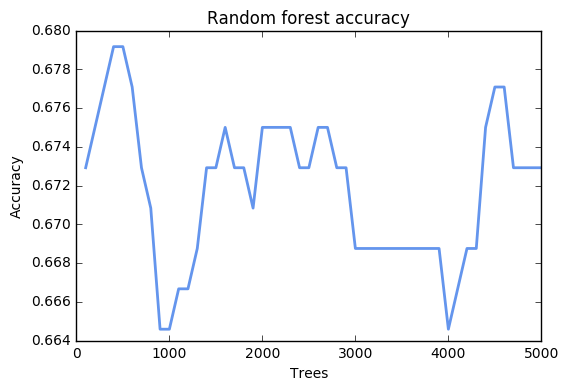

In [125]:
plt.figure()
plt.plot(score[:,0], score[:,1], color="cornflowerblue",
          linewidth=2)
plt.xlabel("Trees")
plt.ylabel("Accuracy")
plt.title("Random forest accuracy")
plt.legend()
plt.show();

In [137]:
#400-500
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=4), x_tr, y_tr, scoring=make_scorer(accuracy_score), cv=5)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators=500, random_state=seed, n_jobs=4), x_tr, y_tr, scoring=make_scorer(accuracy_score), cv=5)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators=4000, random_state=seed, n_jobs=4), x_tr, y_tr, scoring=make_scorer(accuracy_score), cv=5)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators=5000, random_state=seed, n_jobs=4), x_tr, y_tr, scoring=make_scorer(accuracy_score), cv=5)))
#x_train.shape

0.669221479171
0.6620741588
0.666526572499
0.665633715356


In [136]:
print(np.mean(score[0:25,1]))
print(np.mean(score[25:50,1]))

0.67275
0.670916666667


Случайный лес - один из самых устойчивых к переобучению  алгоритмов. Судить о переобучении только по тестовой выборке не совсем корректно. По получившемуся графику выходит, что при 400 - 500 деревьях алгоритм лучше всего работает, а при 4000 хуже всего. Однако если провести кросс-валидацию по этим конкретным параметрам, то разбег значений не такой большой получается. Более того, среднее значение accuracy при кросс-валидации для алгоритма с 500 деревьями ниже, чем с 4000 и 5000.

Так что если случайный лес в нашей задаче и переобучается, то очень медленно и на практике мы вряд ли захотим строить композицию из 5000 деревьев, когда такую же точность можно достичь более простыми алгоритмами

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [114]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


11337728/11490434 [============================>.] - ETA: 0s

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [139]:
x_train.shape

(60000, 28, 28)

In [145]:
from keras.layers import Dense
from keras.models import Sequential
import keras
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(784,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

60000 train samples
10000 test samples


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [150]:
val_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.1,
                              patience=5,
                              verbose=0, mode='auto')

In [153]:
model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1, validation_split=0.2)#, callbacks=[val_stop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 2s - loss: 1.0546 - acc: 0.6266 - val_loss: 1.0214 - val_acc: 0.6436
Epoch 2/10
48000/48000 [==============================] - 2s - loss: 1.0510 - acc: 0.6278 - val_loss: 1.0178 - val_acc: 0.6477
Epoch 3/10
48000/48000 [==============================] - 2s - loss: 1.0402 - acc: 0.6331 - val_loss: 0.9902 - val_acc: 0.6655
Epoch 4/10
48000/48000 [==============================] - 2s - loss: 1.0328 - acc: 0.6402 - val_loss: 0.9985 - val_acc: 0.6541
Epoch 5/10
48000/48000 [==============================] - 2s - loss: 1.0279 - acc: 0.6412 - val_loss: 1.0073 - val_acc: 0.6544
Epoch 6/10
48000/48000 [==============================] - 2s - loss: 1.0196 - acc: 0.6434 - val_loss: 0.9793 - val_acc: 0.6638
Epoch 7/10
48000/48000 [==============================] - 2s - loss: 1.0149 - acc: 0.6472 - val_loss: 0.9915 - val_acc: 0.6528
Epoch 8/10
48000/48000 [==============================] - 2s 

In [154]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.992140903282
Test accuracy: 0.6521


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [155]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [156]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [157]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [158]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [161]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=5,
          verbose=1,
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 198s - loss: 0.0363 - acc: 0.9879 - val_loss: 0.0377 - val_acc: 0.9896
Epoch 2/5
48000/48000 [==============================] - 198s - loss: 0.0315 - acc: 0.9898 - val_loss: 0.0404 - val_acc: 0.9892
Epoch 3/5
48000/48000 [==============================] - 200s - loss: 0.0272 - acc: 0.9915 - val_loss: 0.0390 - val_acc: 0.9891
Epoch 4/5
48000/48000 [==============================] - 205s - loss: 0.0241 - acc: 0.9924 - val_loss: 0.0396 - val_acc: 0.9901
Epoch 5/5
48000/48000 [==============================] - 246s - loss: 0.0224 - acc: 0.9925 - val_loss: 0.0388 - val_acc: 0.9906


In [162]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0305227460379
Test accuracy: 0.9906


__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [165]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          verbose=1,
          validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15
48000/48000 [==============================] - 223s - loss: 0.4357 - acc: 0.8605 - val_loss: 0.0793 - val_acc: 0.9762
Epoch 2/15
48000/48000 [==============================] - 235s - loss: 0.1340 - acc: 0.9596 - val_loss: 0.0548 - val_acc: 0.9837
Epoch 3/15
48000/48000 [==============================] - 227s - loss: 0.0973 - acc: 0.9709 - val_loss: 0.0472 - val_acc: 0.9862
Epoch 4/15
48000/48000 [==============================] - 221s - loss: 0.0828 - acc: 0.9754 - val_loss: 0.0437 - val_acc: 0.9872
Epoch 5/15
48000/48000 [==============================] - 430s - loss: 0.0708 - acc: 0.9783 - val_loss: 0.0386 - val_acc: 0.9891
Epoch 6/15
48000/48000 [==============================] - 455s - loss: 0.0638 - acc: 0.9806 - val_loss: 0.0387 - val_acc: 0.9890
Epoch 7/15
48000/48000 [==============================] - 271s - loss: 0.0585 - acc: 0.9820 - val_loss: 0.0352 - val_acc: 0.9898
Epoch 8/15
48000/48000 [=======================

In [166]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0238388075119
Test accuracy: 0.9923


Был добавлен еще один сверточный слой и два dropout слоя. Время обучения увеличилось. На последней эпохе сеть начала переобучаться - стал рости лос на валидационной выборке. Тем не менее удалось улучшить качество на тесте. Еще большего улучшения можно было бы, наверное, добиться уменьшением learning rate на плато

https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py